 <a href="https://colab.research.google.com/github/Sivivatu/trading/blob/master/Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import initial required packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler
import urllib.parse


In [2]:
file_loc = ".\docs\Alpha Advantage API.txt"
file = open(file_loc, "r+")
apikey = file.readlines(2)
print(apikey)



['API Key: CB5TCTV2SO08EIQE\n']


In [3]:

outputsize = 'full'
getVars = {'function': 'TIME_SERIES_DAILY', 'symbol': 'MSFT', 'apikey': apikey} #https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=demo&datatype=csv}
baseurl = "https://www.alphavantage.co/query?"
url = (baseurl + urllib.parse.urlencode(getVars))

csv_vars = {'function': 'TIME_SERIES_DAILY', 'symbol': 'MSFT', 'apikey': apikey, 'datatype': 'csv', 'outputsize': outputsize}
csv_url = (baseurl + urllib.parse.urlencode(csv_vars))
msft_csv = pd.read_csv(csv_url) #, index_col='timestamp')
msft_csv.sort_values('timestamp', inplace = True)
msft_csv.head()



#:TODO: json option - not working right, think later           
#msft_text = pd.read_csv(csv_url) #, skiprows = 2, delimiter = '\0')
#msft = pd.read_json(url)
#msft.drop(msft.index[:2], inplace = True)
#msft.drop(['Meta Data'], axis = 1, inplace = True) 
#msft.head(5)



,timestamp,open,high,low,close,volume
5362,1998-01-02,129.63,131.50,129.50,131.13,4968500
5361,1998-01-05,131.25,133.63,127.87,130.38,10047200
5360,1998-01-06,129.75,133.00,129.25,131.13,8479300
5359,1998-01-07,129.88,131.19,127.50,129.56,7686600
5358,1998-01-08,128.63,132.13,127.50,130.50,9702400


In [4]:
print(msft_csv.shape)
msft_csv.describe()



(5363, 6)


,open,high,low,close,volume
count,5363.000000,5363.000000,5363.000000,5363.000000,5.363000e+03
mean,49.907955,50.514899,49.301465,49.922832,4.723281e+07
std,30.157157,30.598347,29.691329,30.180271,2.874949e+07
min,15.200000,15.620000,14.870000,15.150000,3.458100e+06
25%,27.090000,27.330000,26.920000,27.125000,2.768005e+07
50%,35.660000,35.910000,35.340000,35.590000,4.236470e+07
75%,65.120000,65.815000,64.485000,65.115000,5.969640e+07
max,178.940000,180.380000,175.750000,179.940000,5.910522e+08


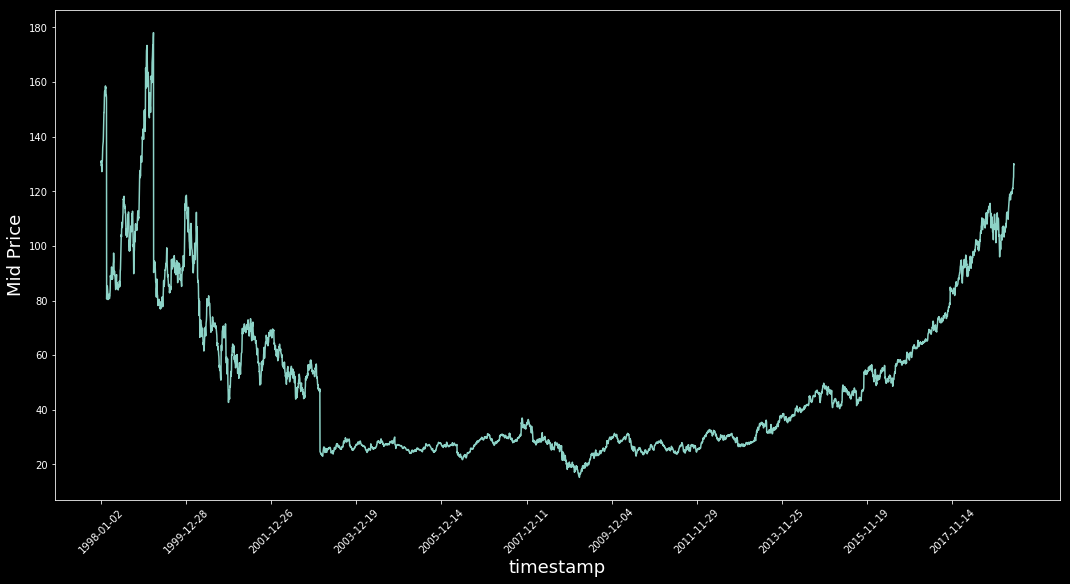

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(msft_csv.shape[0]),(msft_csv['low']+msft_csv['high'])/2.0)
plt.xticks(range(0,msft_csv.shape[0],500),msft_csv['timestamp'].loc[::500],rotation=45)
plt.xlabel('timestamp',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()




In [6]:
msft_csv['mid'] = (msft_csv['low']+ msft_csv['high'])/2.0



In [7]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "mid"



In [8]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0



In [9]:
msft_csv['future'] = msft_csv[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)



In [10]:
msft_csv['target'] = list(map(classify, msft_csv[RATIO_TO_PREDICT], msft_csv['future']))



In [11]:
print(msft_csv.head())
print(msft_csv.tail())


       timestamp    open    high     low   close    volume      mid   future  \
5362  1998-01-02  129.63  131.50  129.50  131.13   4968500  130.500  130.750   
5361  1998-01-05  131.25  133.63  127.87  130.38  10047200  130.750  131.125   
5360  1998-01-06  129.75  133.00  129.25  131.13   8479300  131.125  129.345   
5359  1998-01-07  129.88  131.19  127.50  129.56   7686600  129.345  129.815   
5358  1998-01-08  128.63  132.13  127.50  130.50   9702400  129.815  128.685   

      target  
5362       1  
5361       1  
5360       0  
5359       1  
5358       0  
    timestamp    open      high     low   close    volume       mid    future  \
4  2019-04-22  122.62  124.0000  122.57  123.76  15648724  123.2850  124.7050   
3  2019-04-23  124.10  125.5800  123.83  125.44  24025521  124.7050  125.1850   
2  2019-04-24  125.79  125.8500  124.52  125.01  31256980  125.1850  130.1000   
1  2019-04-25  130.06  131.3700  128.83  129.15  38033892  130.1000  129.7676   
0  2019-04-26  129.70  1

 ## Create Training & testing dataframes

In [12]:
times = sorted(msft_csv.index.values)  # get the times
last_10pct = sorted(msft_csv.index.values)[-int(0.1*len(times))]  # get the last 10% of the times
last_20pct = sorted(msft_csv.index.values)[-int(0.2*len(times))]  # get the last 20% of the times

test_df = msft_csv[(msft_csv.index >= last_10pct)]
validation_df = msft_csv[(msft_csv.index >= last_20pct) & (msft_csv.index < last_10pct)]  
train_df = msft_csv[(msft_csv.index < last_20pct)]  # now the train_df is all the data up to the last 20%


In [13]:
# Import extra packages

from collections import deque
import random


In [14]:
train_df.drop(columns=['timestamp', 'future', 'open', 'high', 'low', 'close', 'volume'], inplace=True)
validation_df.drop(columns=['timestamp', 'future', 'open', 'high', 'low', 'close', 'volume'], inplace=True)
test_df.drop(columns=['timestamp', 'future', 'open', 'high', 'low', 'close', 'volume'], inplace=True)# don't need this anymore.


C:\Users\paulj\AppData\Local\conda\conda\envs\trading\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
train_df.head()


,mid,target
4290,55.475,1
4289,55.560,1
4288,56.075,1
4287,57.230,1
4286,57.350,0


In [16]:
train_data = train_df[RATIO_TO_PREDICT].values
valid_data = validation_df[RATIO_TO_PREDICT].values
test_data = test_df[RATIO_TO_PREDICT].values
train_data[:5]


array([55.475, 55.56 , 56.075, 57.23 , 57.35 ])

In [17]:
train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


In [18]:
train_data.shape



(4291, 1)

In [19]:
scaler = MinMaxScaler()


In [20]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 250
for di in range(0,4000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


In [21]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data and validation data
valid_data = scaler.transform(valid_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)


In [22]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(4291):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA
# TODO: need to work out if range is for entirety of training set

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,valid_data, test_data],axis=0)


In [23]:
# TODO: Run from here
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [24]:
X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(valid_data)):
    X_valid.append(valid_data[i-SEQ_LEN:i])
    y_valid.append(valid_data[i+(FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))


In [25]:
X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_data[i+(FUTURE_PERIOD_PREDICT-1)])
    
X_test, y_test = np.array(X_test), np.array(y_test)


In [26]:
print(y_train.shape)
print(y_valid.shape)


(4231,)
(476,)


In [27]:
X_train_2 = []
y_train_2 = []
for i in range(SEQ_LEN, len(train_data)):
    X_train_2.append(train_data[i-SEQ_LEN:i])
    y_train_2.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))


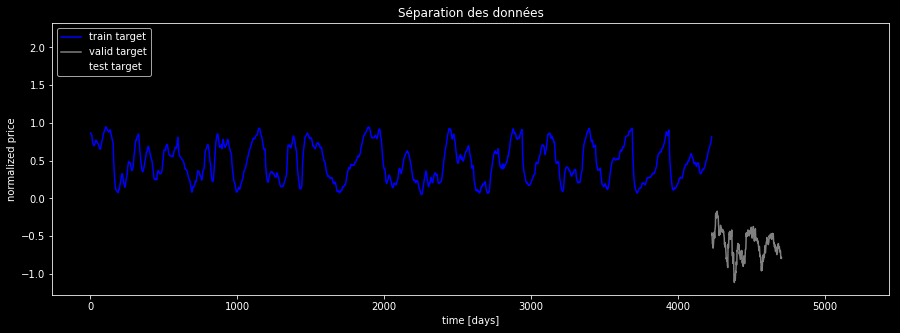

In [28]:
## show predictions
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Séparation des données')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');


In [29]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
